# Приближенный поиск ближайших соседей

## 1  Введение

-  В проекте требуется создать ранжирующую модель, которая среди миллионов товаров ищет пять, наиболее подходящих по запросу. 

### 1.1  План выполнения проекта

 - Загрузить данные. 
 
 
 - Провести EDA.
 
 
 - Разработать ранжирующий алгоритм методом приближенного поиска ближайших соседей, используя возможности библиотеки FAISS.
 
 
 - Измерить качество алгоритма метрикой accuracy@5.
 
 
 - Проверить работу алгоритма на разных параметрах. 
 
 
 - Проверить алгоритм с лучшей оценкой на тестовой выборке.
 
 
### 1.2 Данные 

 ***base.csv*** - таблица, содержащая около трех миллионов Id товаров, которые описываются 72 зашифрованными признаками; 
  
 ***train.csv*** - таблица, содержащая 100 000 Id запросов, которые описываются 72 зашифрованными признаками, и целевой признак каждого запроса (Target). 
 
 ***validation.csv*** - таблица, содержащая 100 000 Id запросов, которые описываются 72 зашифрованными признаками. 
 
 ***validation_answer.csv*** - таблица, содержащая 100 000 Id запросов из таблицы validation.csv и правильные ответы на эти запросы  в виде Id товаров из таблицы base.csv. 

## 2  Загрузка и изучение данных


In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import warnings
import faiss
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# настраиваем отображение 
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 250)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# загружаем данные (задаем индексы значениями ID)
data_train = pd.read_csv('/Volumes/Datasets/Мастерская_2/data/train.csv', index_col=0)
data_valid = pd.read_csv('/Volumes/Datasets/Мастерская_2/data/validation.csv', index_col=0)
data_base = pd.read_csv('../Downloads/base.csv', index_col=0) 

data_valid_answer = pd.read_csv('/Volumes/Datasets/Мастерская_2/data/validation_answer.csv')

In [3]:
# смотрим размер датасетов
print(data_base.shape)
print(data_train.shape)
print(data_valid.shape)
print(data_valid_answer.shape)

(2918139, 72)
(100000, 73)
(100000, 72)
(100000, 2)


- Датасет с базой очень большой, поэтому данные по нему выведем отдельно. 

In [4]:
# выводим общую информацию
data_base.info()
# выводим первые строки
display(data_base.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

In [5]:
# смотрим количество пропусков и дубликатов
print(data_base.duplicated().sum())
data_base.isna().sum()

0


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
dtype: int64

In [6]:
# знакомимся с данными, выводим пять случайных строк, явные и относительные дубликаты, пропуски
# и распределение

d = {'data_train': data_train, 
     'data_valid': data_valid, 
     'data_valid_answer': data_valid_answer}
for a, i in d.items():
    
    # дубликаты
    print()
    print('Датасет:',a,'абсолютное количество явных дубликатов:',i.duplicated().sum())    
    print('Датасет:',a,'относительное количество явных дубликатов:',i.duplicated().sum()/i.shape[0])
    print()
    
    # пропуски
    print('Датасет:',a,'абсолютное количество пропусков:')
    print(i.isna().sum().sort_values()) 
    print()
    print('Датасет:',a,'относительное количество пропусков:')    
    print((i.isna().sum()/i.shape[0]).sort_values())
        
    # строки и распределение
    display(i.sample(5))
    
    print()
    display(i.describe())
    
    print()
    i.info()


Датасет: data_train абсолютное количество явных дубликатов: 0
Датасет: data_train относительное количество явных дубликатов: 0.0

Датасет: data_train абсолютное количество пропусков:
0         0
51        0
50        0
49        0
48        0
47        0
46        0
52        0
45        0
43        0
42        0
41        0
40        0
39        0
38        0
44        0
53        0
54        0
55        0
70        0
69        0
68        0
67        0
66        0
65        0
64        0
63        0
62        0
61        0
60        0
59        0
58        0
57        0
56        0
37        0
71        0
36        0
34        0
14        0
13        0
12        0
11        0
10        0
9         0
15        0
8         0
6         0
5         0
4         0
3         0
2         0
1         0
7         0
16        0
17        0
18        0
33        0
32        0
31        0
30        0
29        0
28        0
27        0
26        0
25        0
24        0
23        0
22        0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
39593-query,-126.148150,7.567683,-74.319275,-114.28582,190.87170,-37.996605,-443.621487,20.762451,130.48653,171.99094,-150.24542,-88.097690,-47.640724,-6.379213,172.281070,-16.583752,7.790508,69.021730,-225.52588,-79.501950,-72.226974,1507.231274,-61.573338,31.522255,38.730515,813.770071,-82.872150,13.934490,-116.811670,155.17350,-56.328304,-146.87030,134.13345,-803.390708,61.565735,29.982655,-14.900561,-130.91235,-102.12592,-50.238266,5.987926,13.801950,-126.99581,155.64122,-61.441417,70.868320,-17.700768,-32.063354,-7.922344,-51.269127,80.235886,-38.501810,65.006540,-31.495865,86.799790,83.74107,-120.313446,69.316970,-98.37377,-412.024330,-24.186443,-110.10880,-121.163240,1.058186,-151.00223,180.563049,68.919174,-16.613815,48.231680,138.814760,-416.231502,1.438702,719454-base
34269-query,-52.764168,6.861452,-88.740820,-137.75128,127.96642,-96.937614,-329.022620,-31.322435,128.98862,241.95612,-161.97823,-35.235523,-28.726448,0.906612,127.237915,-43.882587,-3.475658,-36.923960,-125.40015,-78.891150,-186.107180,1507.231274,-59.463726,94.095470,53.423744,813.770071,53.010864,11.302559,-60.311333,147.02283,-7.350620,-195.46220,78.97080,-447.850095,61.339980,54.830303,-12.774291,-137.85521,-125.19780,-14.670315,2.310976,3.958662,-131.77360,157.19226,-61.441417,-19.251911,-136.173930,-107.036410,-7.801430,-113.789444,-19.034489,-64.565710,85.008700,-133.881500,90.315160,67.97718,-136.288820,-37.266396,-202.55247,-392.410889,-59.763058,-118.76979,-74.253075,39.384792,-137.00294,57.003486,67.770355,99.647290,17.654388,102.208824,-1074.464888,-7.654377,1616468-base
52224-query,-55.842438,11.449638,-4.673550,-134.31410,127.35019,-115.845580,-183.225860,-182.670460,128.41837,105.83455,-83.61365,-183.615420,-75.394170,38.370340,85.257130,-27.689625,49.507767,-78.505950,-107.45442,-79.568375,-89.406075,1507.231274,-1.027533,5.366505,16.994122,813.770071,-41.087640,14.621725,23.618317,158.48560,-53.768394,-132.21774,133.40799,-481.586956,30.813705,18.936264,-24.167072,-154.87244,-98.12826,-64.968460,19.274666,7.841720,-156.66602,131.66977,-61.396889,85.982370,-147.868590,-142.387800,-7.088154,-68.674900,19.026897,21.718172,90.438805,-50.486060,99.215324,86.26901,-129.773500,110.416620,-193.40347,-423.307689,-124.176240,-139.75555,-49.901455,26.070457,-112.34877,153.335657,66.787750,-24.080425,-107.166420,99.339050,-1074.464888,-166.882400,2113213-base
64479-query,-38.528362,8.940105,-74.460660,-159.34958,90.61816,-96.093760,-727.542041,115.470420,128.38760,73.35481,-77.41515,-90.099240,-22.381174,33.965690,166.441220,2.453308,-3.832268,26.107609,-120.81596,-79.372284,-33.428223,1507.231274,0.988096,25.063177,-24.411816,813.770071,6.558083,19.291210,26.766716,155.42918,24.087894,-230.17569,98.84862,-966.607000,-16.496136,68.151190,-32.048744,-156.80757,-115.05523,-6.907059,-14.419727,5.194134,-160.81290,137.70995,-16.662981,76.797260,-73.623560,-141.619670,117.377380,-54.383293,88.484560,-14.652057,57.192406,-101.798780,78.327225,73.77016,-137.917450,31.206276,-44.07332,-378.260480,-86.624790,-130.58060,-90.573135,-8.219269,-168.89694,-81.338230,68.467810,-25.905537,9.085548,141.631520,-1074.464888,-68.789800,2078060-base
54816-query,-96.277610,6.267898,-52.412060,-171.29158,83.76984,-69.392090,-387.773078,106.630750,110.59305,171.57863,-131.17023,-72.993680,34.985683,-37.237434,186.110660,-21.679588,-11.650210,-79.529050,-178.22792,-79.757500,-78.500580,1507.231274,-63.642330,52.599625,16.718548,813.770071,-139.600890,8.176849,-67.967514,137.44225,-43.421370,-141.62510,68.01685,-156.249890,83.821465,63.631313,-9.493752,-143.75874,-83.59244,-35.382520,-7.688454,-4.546443,-97.23102,137.79529,-34.254480,62.101070,34.994553,-88.382220,35.805313,-11.033615,-31

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,-141.168584,-69.228444,-42.559541,6.506719,149.077582,-23.942253,-2.219093,-12.964439,-138.714610,-79.159795,-97.474574,1297.269578,-3.600685,55.908014,23.470181,742.788817,-64.970553,16.368072,-86.201170,152.098083,-13.659323,-144.506022,89.747894,-587.551768,36.468210,73.109595,-13.866967,-146.487267,-118.336458,-41.131969,-9.261504,4.139978,-104.928806,122.240784,-40.320211,59.051981,-84.054387,-140.787854,46.137851,-34.136875,29.462927,-22.343451,67.581086,-120.052756,88.193676,69.538752,-132.336967,14.452681,-120.301843,-315.282239,-66.378660,-130.672183,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,41.607785,51.258647,40.819544,37.593800,34.167843,13.024184,20.978943,55.210920,48.737245,0.775560,28.382144,375.123794,50.063680,35.617513,40.802653,191.052074,63.160650,4.828575,49.511818,10.392531,29.191689,35.816357,28.312124,273.294442,39.756311,20.008170,25.824911,10.383975,13.578397,19.868303,8.295381,5.922103,56.519443,48.109909,14.739497,31.088173,66.055063,59.851232,46.328286,59.325454,60.934591,54.991787,12.988132,55.920785,4.824051,12.339684,7.952113,49.234745,55.730177,210.657513,64.913422,9.408099,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,-330.570600,-352.405200,-214.742460,-145.860280,8.818390,-82.645004,-91.657020,-247.589280,-326.648740,-82.637184,-228.808260,136.873137,-211.971800,-87.323780,-122.584274,-61.803358,-338.562500,-6.629074,-285.668700,111.387250,-130.444920,-290.124000,-25.550720,-1044.135662,-119.903810,-11.926712,-124.560380,-193.918150,-166.078460,-123.062420,-43.063824,-18.980648,-324.943570,-67.540375,-63.102401,-64.789690,-327.322720,-365.060880,-129.879180,-280.371830,-250.337570,-236.148470,18.477040,-354.915700,66.068665,18.104557,-161.189320,-183.849880,-330.638180,-681.029305,-358.460450,-169.566400,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,-168.599020,-103.048815,-69.801705,-18.815189,126.369124,-32.379752,-16.455603,-49.612492,-171.661355,-79.656816,-115.407545,1248.126198,-37.047511,31.436791,-5.051067,813.770071,-106.860569,13.187895,-119.613590,145.143008,-32.812503,-168.535163,70.432237,-803.390708,9.505674,59.978086,-30.926924,-153.339210,-127.603408,


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
126286-query,-68.36684,9.053011,36.498330,-142.11372,68.052980,-103.914764,-759.626065,38.649400,122.893510,70.55913,-159.85107,-136.518520,-89.972565,-4.477044,161.82384,-19.395020,1.673130,-7.956300,-72.731940,-78.069824,-99.424720,1507.231274,-7.913494,30.244675,68.857110,813.770071,-112.470410,11.085695,-64.090990,146.61081,-0.279183,-100.07300,113.814330,-687.568425,10.052853,81.491005,-54.133190,-143.30860,-126.190590,-31.771930,-22.510916,-1.484885,-245.45746,130.352650,-21.427871,62.701730,-170.05602,-72.076380,22.631355,-46.265580,67.644590,-69.152794,39.153540,-132.803900,82.457780,52.838722,-132.87940,37.513920,-195.171360,-450.732845,-30.646881,-129.55573,-117.373550,29.758265,-67.21612,-133.208098,68.044080,62.017210,-3.663322,134.82848,-860.822658,-43.119030
165899-query,-109.33520,1.823475,-12.918007,-131.37508,71.420975,-58.928400,-617.513492,-1.046656,135.097350,170.90945,-132.37256,-14.432888,-42.912660,-4.358955,230.59183,-19.576178,-18.822205,9.847666,-57.646706,-79.013290,-99.190350,1507.231274,3.886074,30.025047,38.956875,813.770071,3.828804,12.754488,-116.192170,158.34459,10.752316,-115.96786,84.996605,-771.296708,27.800156,55.585945,-39.511280,-151.71810,-105.026634,-20.481140,0.449644,-3.861225,-149.00310,160.240980,-16.143260,38.754310,-137.30557,-103.916900,13.626392,-5.018230,58.717712,-33.213814,33.829155,-146.970930,89.131870,76.301796,-137.67918,97.321750,-16.658043,-565.680483,0.444839,-145.81802,-103.592270,34.623040,-211.23764,140.246724,64.903380,40.796944,29.807327,96.58792,-367.167357,-53.258484
133333-query,-79.81856,2.698875,-129.720210,-150.44304,174.693620,-28.871223,-170.816084,-25.394804,123.016320,139.17412,-171.74484,-122.906660,4.949108,-68.149820,150.87642,13.756205,43.912853,65.877960,-134.638260,-78.943250,-67.439415,1507.231274,-42.421005,112.394390,79.841125,813.770071,-46.742348,18.783213,-44.945194,146.04434,-11.332378,-69.96584,70.774610,-156.249890,-26.707432,70.205154,20.937400,-158.09400,-97.289020,-32.671684,-12.176474,-0.506446,-52.94937,114.699646,-20.873245,65.061810,-140.25797,-100.623566,50.138940,-23.436127,1.564480,-101.935394,67.560590,-117.449410,92.540120,66.206810,-139.29974,87.750420,-142.546330,-311.124319,49.940437,-128.02217,-117.805620,56.013650,-192.88867,149.907667,72.697975,64.857820,66.779470,108.69798,-313.780200,-46.994810
176892-query,-78.37275,6.730221,-93.717360,-154.60675,127.291660,-54.448166,-722.870840,-4.354660,124.863480,128.26329,-108.05467,-75.243390,39.796665,-79.858380,153.96526,-31.636559,21.420862,27.919490,-142.438570,-77.629040,-131.000630,1507.231274,42.124860,37.590730,-7.223129,813.770071,-102.555270,20.266380,-114.335880,167.24045,-10.661789,-131.33337,88.186280,-771.296708,12.150694,107.138920,-2.043261,-138.32037,-108.829094,-84.122990,-21.589952,8.015932,-120.31358,171.058070,-28.860242,63.099087,-47.05927,-129.829960,31.296326,32.889664,-70.597140,17.747522,50.783245,-119.997940,84.405360,53.267487,-141.58917,-2.303424,-103.859024,-194.716847,1.545700,-127.17575,-60.093950,40.548607,-188.70807,96.273018,67.902370,-39.067750,29.755974,135.98660,-416.605235,-137.634220
154758-query,-104.17174,7.267980,-93.207340,-140.36842,151.440060,-97.500780,-626.498797,92.439920,120.306854,133.35864,-127.54518,-69.528140,-63.533657,74.863460,192.27966,-38.350574,-40.151380,-41.887480,-171.878220,-80.050250,-68.757580,1507.231274,-3.884287,35.462334,26.078012,813.770071,-9.469971,15.790542,12.590355,143.19840,-2.465122,-163.49094,28.672280,-1018.469545,-3.485069,116.975130,-16.815481,-128.04494,-128.395540,-70.694180,8.734684,-0.123369,-125.54663,64.539760,-56.665346,78.587326,-65.46547,-204.520940,38.073696,19.414951,37.350320,-55.310623,43.064790,-122.964355,81

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,-141.215384,-69.340237,-42.626768,6.272022,149.006081,-23.961728,-2.009594,-13.151269,-138.540600,-79.162680,-97.356361,1301.395163,-3.439855,56.097825,23.357262,741.156981,-64.986388,16.367853,-86.139332,152.078754,-13.476064,-144.568331,89.709031,-588.597042,36.554961,73.085400,-13.889099,-146.461500,-118.391474,-40.992214,-9.193917,4.157828,-104.775965,122.095524,-40.311826,59.123753,-83.620997,-141.003063,46.187760,-34.154328,29.404870,-22.542637,67.486142,-120.307717,88.174847,69.495540,-132.377437,14.411927,-120.381837,-316.401557,-66.614887,-130.653256,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,41.568432,51.483403,40.858017,37.845939,34.031665,13.014670,20.993654,55.340411,48.790143,0.777431,28.503558,371.543911,50.291410,35.599512,40.849607,193.199671,63.274623,4.845841,49.511970,10.406558,29.275776,35.911251,28.430405,273.788805,39.610961,20.044353,25.802824,10.389778,13.602543,19.845968,8.364438,5.910225,56.986969,48.130993,14.753263,31.126990,65.925312,59.595488,45.996789,59.611850,60.943297,55.140398,13.036243,56.107653,4.809309,12.324416,7.894675,49.387024,55.818220,211.131373,65.195278,9.426921,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,-321.544250,-363.493320,-204.299130,-144.100740,-14.816055,-78.597450,-86.843280,-272.565600,-329.860170,-82.665300,-231.376650,136.846377,-208.900850,-84.224530,-138.217000,-61.879841,-341.962220,-6.662937,-282.249330,110.357254,-150.154720,-281.123540,-24.076744,-1044.135662,-117.473145,-17.641396,-124.311615,-194.132930,-166.124450,-126.336075,-43.321170,-19.319794,-326.301300,-79.304720,-63.102401,-76.792040,-365.282530,-375.452200,-121.267914,-277.375920,-279.886380,-234.521500,12.404751,-381.609380,65.986030,17.301888,-162.872990,-156.581590,-329.700800,-681.038139,-339.966340,-168.735570,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,-168.562772,-103.338022,-70.147153,-19.089412,126.442184,-32.356516,-16.392179,-49.942476,-171.695623,-79.665475,-115.390365,1248.126198,-36.891637,31.741733,-5.265194,813.770071,-107.339855,13.182383,-119.527813,145.126130,-32.815898,-168.729353,70.166879,-803.390708,9.700724,59.971492,-30.786210,-153.332742,-127.66153


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 2

,Id,Expected
32941,132941-query,933840-base
60828,160828-query,578213-base
94400,194400-query,1751984-base
32863,132863-query,958479-base
57746,157746-query,1688962-base


,Id,Expected
count,100000,100000
unique,100000,91502
top,132171-query,210304-base
freq,1,7



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


- Данные зашифрованы, пропускок нет, дубликатов нет, все признаки числовые, кроме значений в столбцах Expected и Target. 

- Признаки имеют разную размерность.

- Так как data_train - это выборка из data_base, чтобы сэкономить ресурсы, вместо data_base будем детально изучать data_train. 

- Заменим тип числовых данных на менее энергоемкий.

In [7]:
# меняем тип данных с 64 на 32
def change_type(data, columns, type):
    data[columns
        ] = data[columns].astype(type)
    return data 

data_base = change_type(data_base, data_base.columns,'float32')
data_train = change_type(data_train, data_train.columns[:-1],'float32')
data_valid = change_type(data_valid, data_valid.columns,'float32')
# проверяем
print(data_base.dtypes.value_counts())
print(data_train.dtypes.value_counts())
print(data_valid.dtypes.value_counts())

float32    72
dtype: int64
float32    72
object      1
dtype: int64
float32    72
dtype: int64


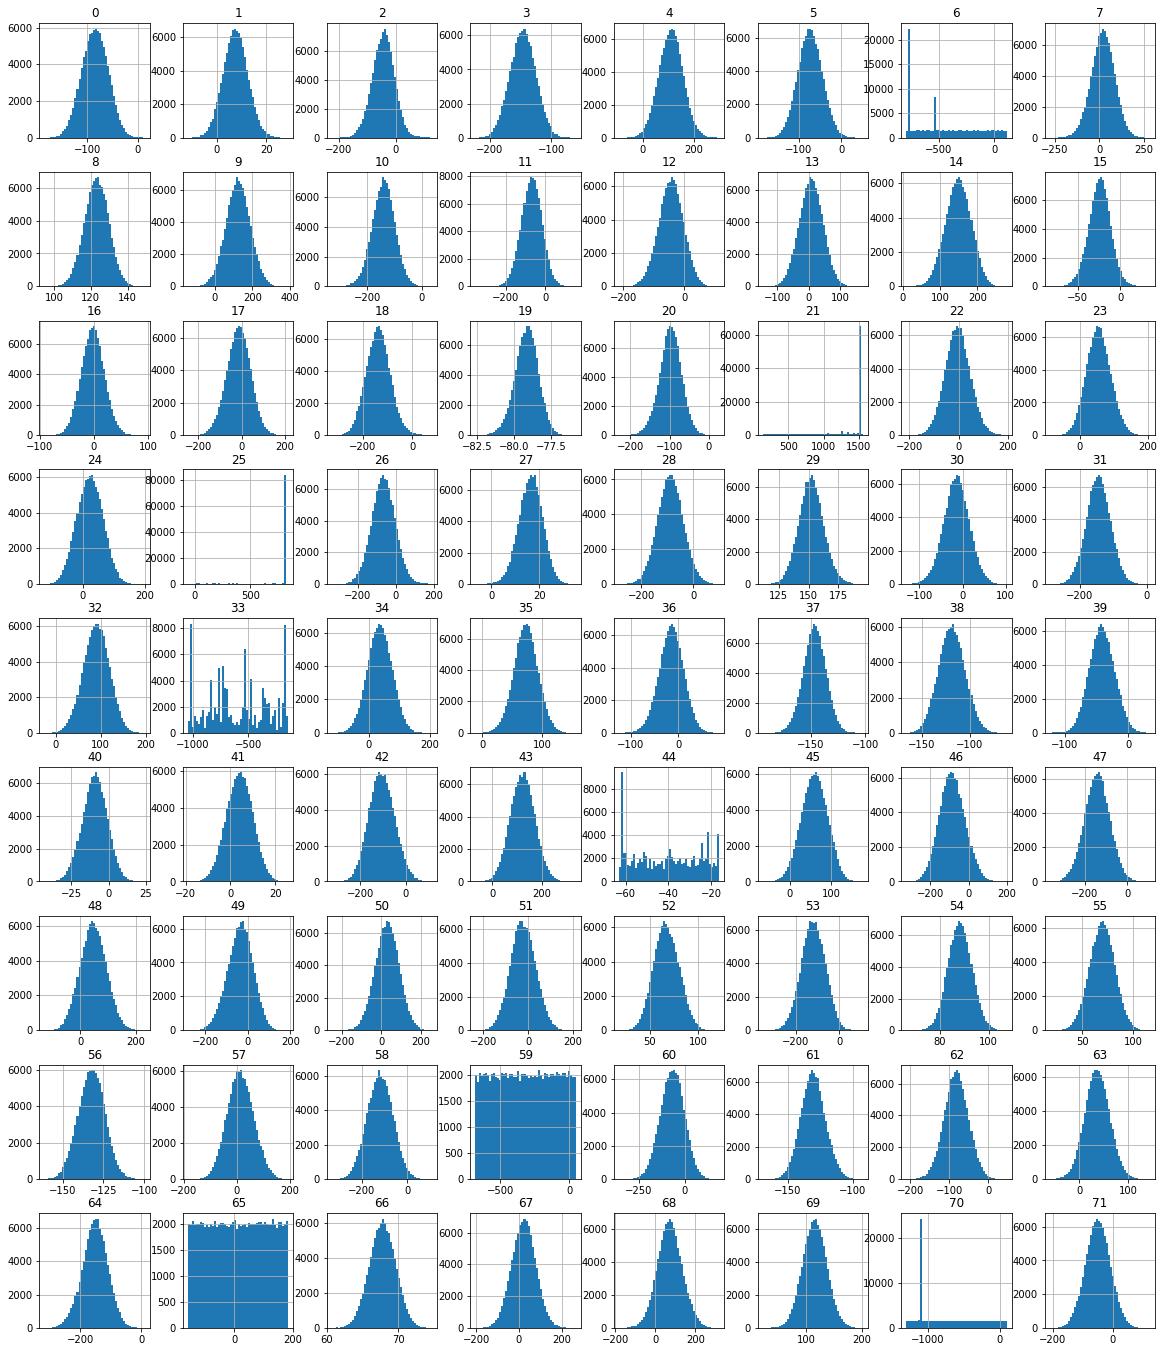

In [8]:
# смотрим столбцы с числовыми данными на гистограмме в тренировочном датасете
data_train.hist(bins=50, figsize=[20,24]);

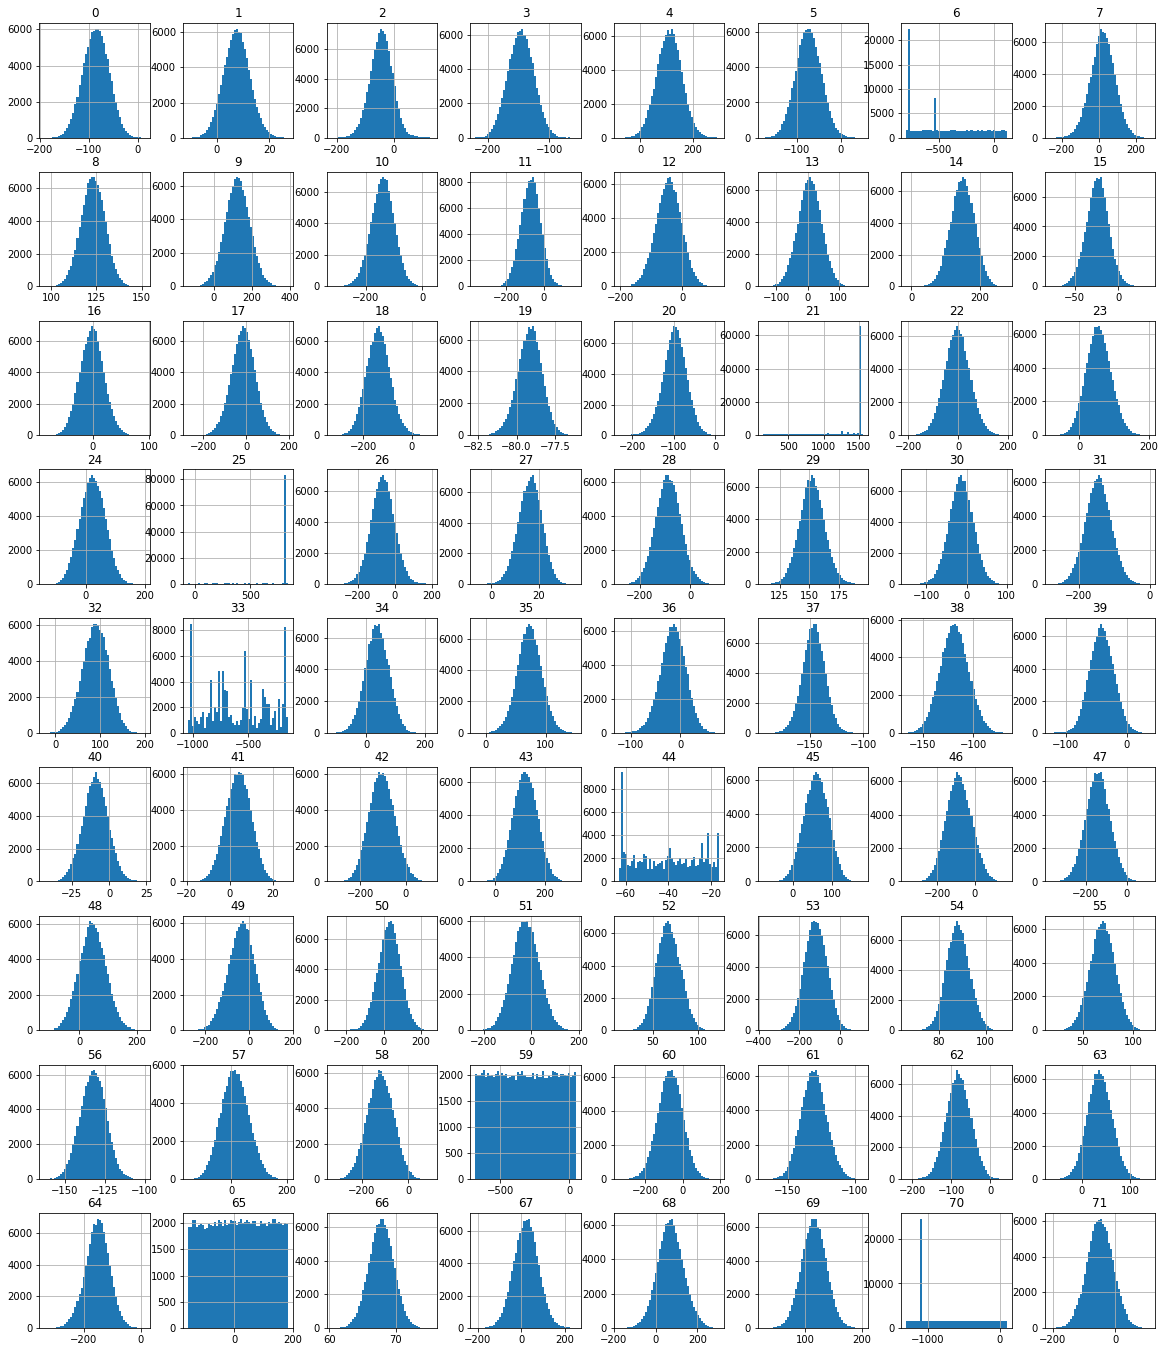

In [9]:
# смотрим столбцы с числовыми данными на гистограмме в валидационном датасете
data_valid.hist(bins=50, figsize=[20,24]);

- Данные во всех признаках распределены нормально, кроме 6 столбцов, где данные распределены неравномерно и есть явные выбросы. В обоих датафреймах распределение данных идентично.

- Рассмотрим отдельно на графиках признаки с ненормальным распределением.

In [10]:
# выбираем столбцы 
columns_plot = ['6','21','25','33','44','59','65','70']
# задаем функцию
def plot_hist(data, bins, size):
        
    for column in columns_plot:
        
        plt.figure(figsize=size)
        data[column].plot(bins=bins, kind='hist')                            
        plt.grid=True
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title('Распределение числовых значений в данных')
        plt.show()         

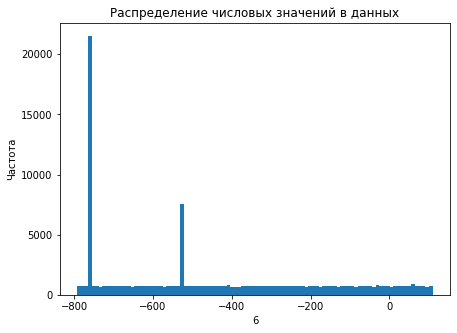

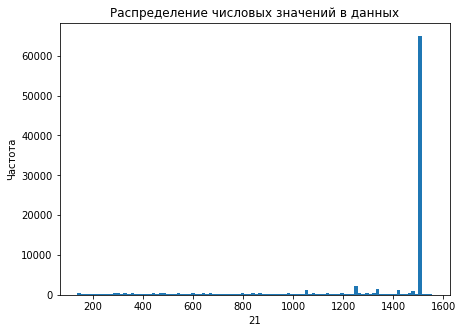

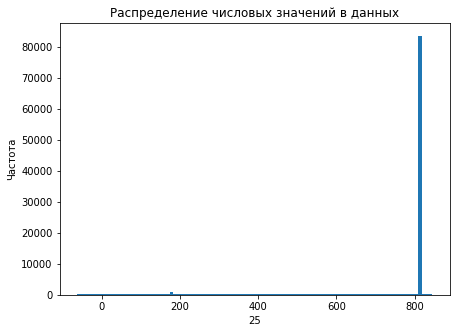

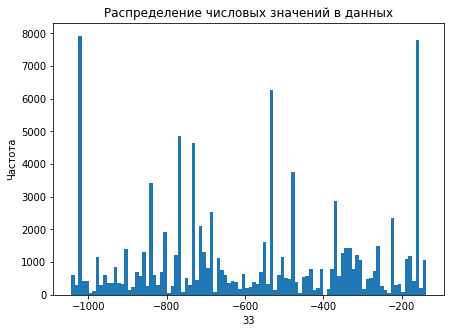

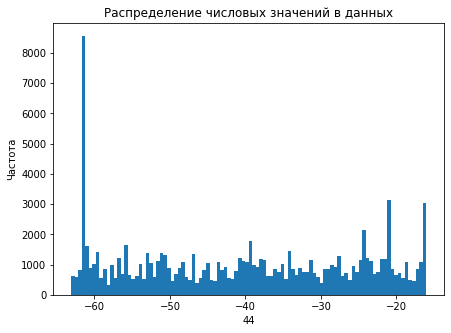

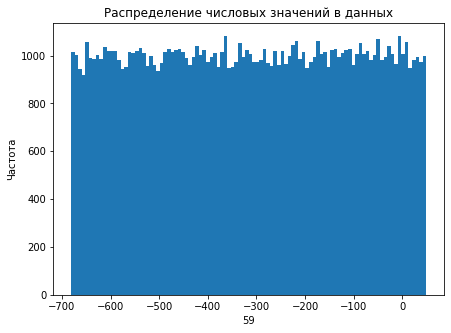

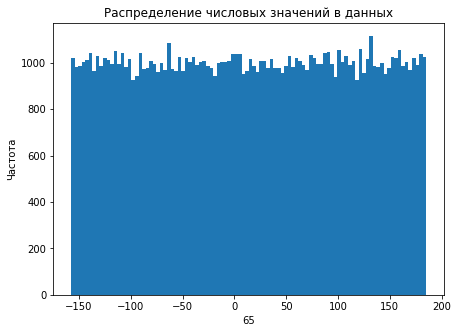

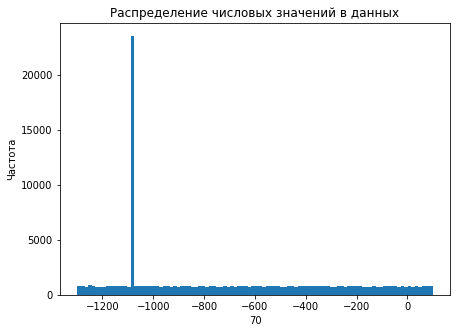

In [11]:
# выводим графики
plot_hist(data_train, 100, [7,5])

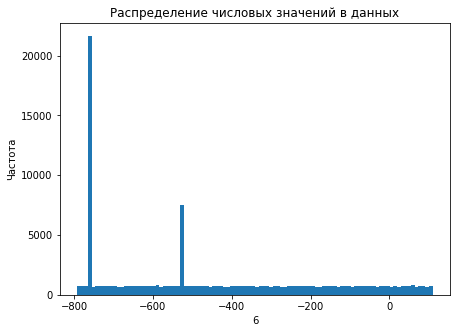

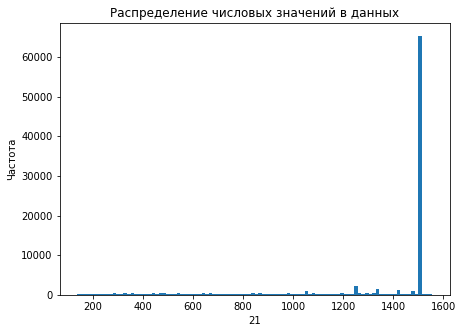

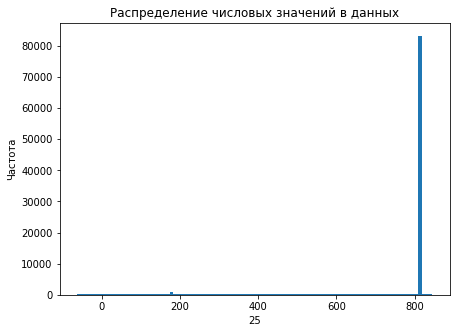

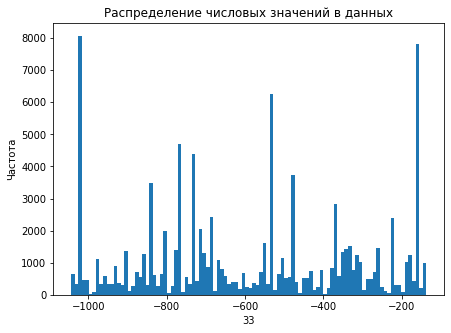

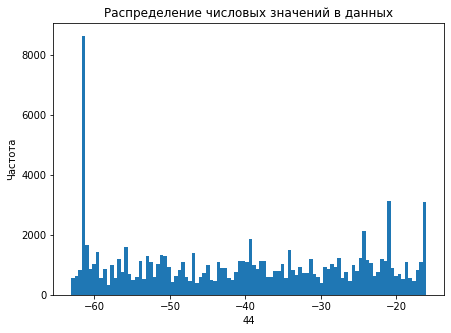

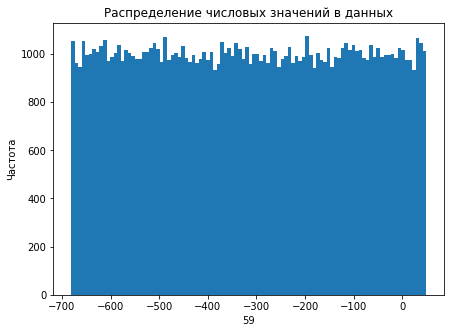

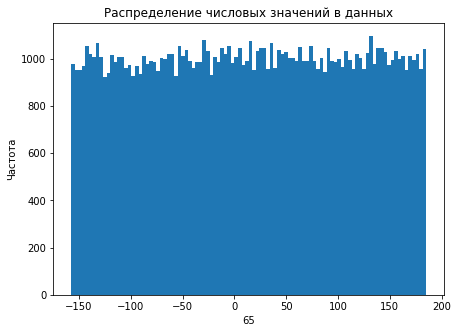

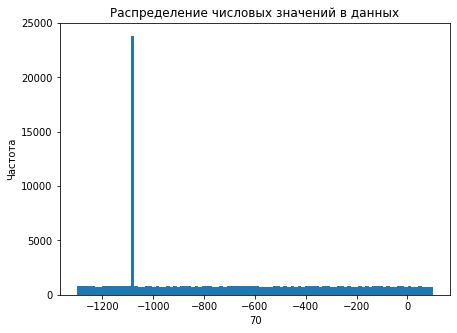

In [12]:
# выводим графики
plot_hist(data_valid, 100, [7,5])

 - За исключением явных выбросов в столбцах 6, 21, 25, 33, 44 и 70, данные в основном распределены однородно. 

- Посмотрим на корреляцию признаков методом Спирмена

In [13]:
# строим корреляционную матрицу
data_train.corr(method='spearman')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.007973,0.000236,-0.008457,-0.024337,-0.015670,0.009347,-0.000938,-0.014553,-0.001835,0.011981,0.017666,0.002779,0.006917,0.016842,0.005206,-0.010882,-0.019035,0.020473,0.008693,0.003396,0.011158,0.010740,-0.034025,-0.001639,0.020764,-0.002925,0.005066,0.029738,0.023567,0.005592,-0.001329,0.003087,0.028880,0.009843,0.017936,-0.021228,-0.022159,0.030962,0.007726,-0.024960,-0.004074,-0.012435,0.008619,0.029071,0.031401,0.004979,0.025302,-0.007359,0.008277,0.014002,-0.007416,-0.010402,-0.023555,-0.009745,0.024453,0.025127,-0.015380,0.019190,0.000362,0.036605,-0.000024,0.007347,-0.017425,-0.014383,-0.001314,-0.021008,-0.000506,-0.008953,-0.023080,-0.018389,-0.023073
1,0.007973,1.000000,-0.003328,0.006766,-0.001508,-0.012690,0.011793,0.010525,-0.001832,-0.000110,0.015494,0.005419,-0.012643,0.025395,-0.006709,-0.007040,0.017297,0.018339,0.005305,0.022767,0.037150,-0.015107,-0.006575,0.003699,0.020967,0.013480,0.007018,0.012725,-0.021580,0.017372,0.020175,0.019429,0.014426,0.018956,-0.020985,-0.002415,0.013067,0.018082,0.006084,0.030910,-0.002566,0.017241,-0.017177,-0.004954,0.030120,-0.007044,-0.003309,-0.019342,-0.026831,-0.015020,-0.003264,0.009953,-0.005195,-0.003673,0.001689,0.020707,-0.002281,0.018449,-0.012365,-0.004540,-0.041417,-0.019726,-0.005179,-0.010180,-0.027128,-0.003197,-0.005184,-0.015333,-0.008043,0.012949,-0.013641,0.018768
2,0.000236,-0.003328,1.000000,-0.010442,-0.022934,-0.000464,-0.009142,-0.014187,0.018726,0.014827,-0.012459,-0.011129,0.006300,-0.011846,-0.000536,-0.003727,0.012457,-0.019088,-0.014977,-0.020613,-0.026371,0.020889,-0.007428,-0.003815,-0.009262,0.006577,0.001047,-0.014450,0.015089,0.022230,0.016124,0.005373,0.007689,0.017676,-0.011908,0.000705,-0.014976,-0.002026,0.013498,-0.043189,-0.001929,-0.010785,-0.017133,0.004513,0.028983,-0.022782,-0.003652,-0.009591,0.018653,0.001044,0.011611,0.012769,-0.037524,0.008713,-0.000505,0.005965,0.008533,-0.027649,0.004625,0.001599,-0.036080,-0.009713,-0.031692,-0.007640,0.010214,-0.003100,-0.031947,-0.016088,-0.014936,-0.010718,0.004517,0.002386
3,-0.008457,0.006766,-0.010442,1.000000,0.007298,-0.008235,-0.005348,0.008875,-0.001338,0.030471,0.009380,0.003933,0.000412,0.003950,-0.024041,0.007407,0.000256,0.012034,0.020899,0.002994,0.009999,-0.024847,0.030515,-0.003725,0.014049,-0.010609,0.003134,-0.002497,-0.001920,-0.014260,0.002023,-0.009743,0.034527,-0.010304,-0.015240,-0.015683,-0.013803,0.005932,-0.002991,-0.013234,0.018140,0.009469,-0.004280,-0.012087,-0.012463,0.024182,-0.010547,0.004804,0.006875,-0.021788,0.014977,-0.020178,0.008438,0.024624,0.018320,-0.010776,-0.010050,-0.001253,0.000199,-0.000623,0.034209,-0.000300,0.010718,-0.015441,-0.011983,-0.000785,0.011550,0.007414,0.024364,-0.003318,0.003796,0.013820
4,-0.024337,-0.001508,-0.022934,0.007298,1.000000,-0.001128,0.022814,0.000077,-0.018991,0.006473,-0.006113,-0.004896,0.001563,0.026364,-0.016216,-0.014836,-0.015790,-0.004844,0.024927,-0.030654,0.001862,-0.017050,-0.005399,0.007788,-0.007619,0.025931,0.003555,0.003223,0.014989,-0.004222,-0.022144,0.009785,-0.007232,0.012460,-0.007997,-0.024239,0.049186,0.008757,0.017631,0.020343,0.016594,0.000975,-0.014314,0.007216,0.028925,0.031628,-0.024056,-0.029214,-0.003203,-0.004375,-0.015019,-0.003438,-0.053863,-0.004894,0.010833,-0.024392,-0.007824,-0.007592,0.005946,0.001381,-0.013052,0.011963,0.010858,0.006065,0.004413,0.001716,0.001177,-0.006910,-0.010388,-0.010206,0.000471,-0.014159
5,-0.015670,-0.012690,-0.000464,-0.008235,-0.001128,1.000000,-0.049825,-0.001019,-0.011664,0.014666,-0.029759,-0.030269,-0.010353,0.003192,-0.005557,0.009660,-0.008912,-0.002775,0.023505,-0.032290,-0.004675,-0.033695,0.000314,0.021120,0.002187,-0.011740,0.019457,0.004563,-0.006388,-0.024350,0.007174,-0.004031,0.014739,-0.027640,-0.008104,-0.019095,-0.014607,0

- Существенной корреляции между признаками не наблюдается. 

- Посмотрим на разброс даннных, чтобы определить выбросы. Так как датасеты идентичны, рассмотрим только одну выборку. 

In [14]:
# смотрим разброс данных на диаграмме разброса
def boxplotly(data):
    
    plt.figure(figsize=(15, 10))    
    sns.boxplot(data=data)
    plt.xlabel('Признаки')
    plt.ylabel('Значения')
    plt.title('Распределение значений в данных')
    plt.show()   

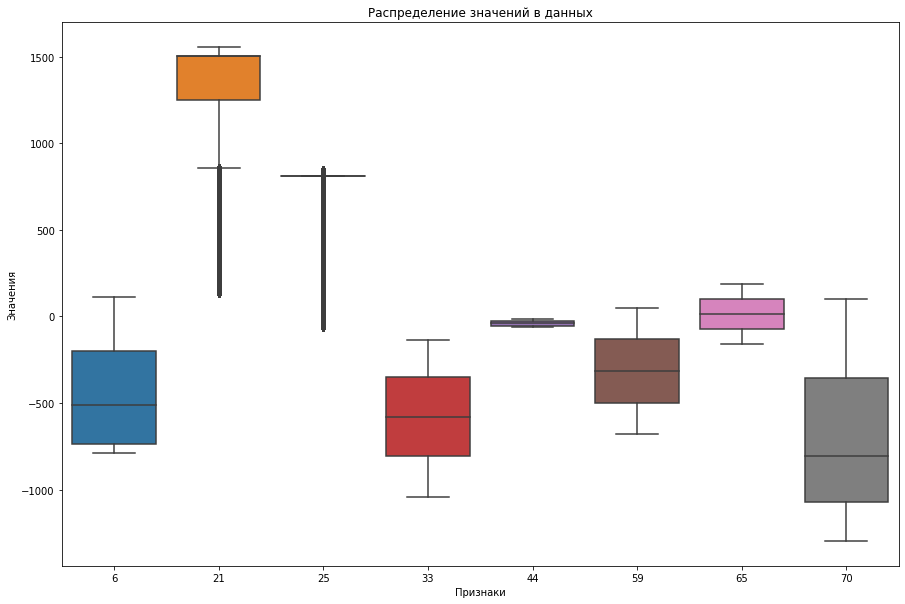

In [15]:
# смотрим разброс в данных
columns=['6','21','25','33','44','59','65','70']
boxplotly(data_train[columns])

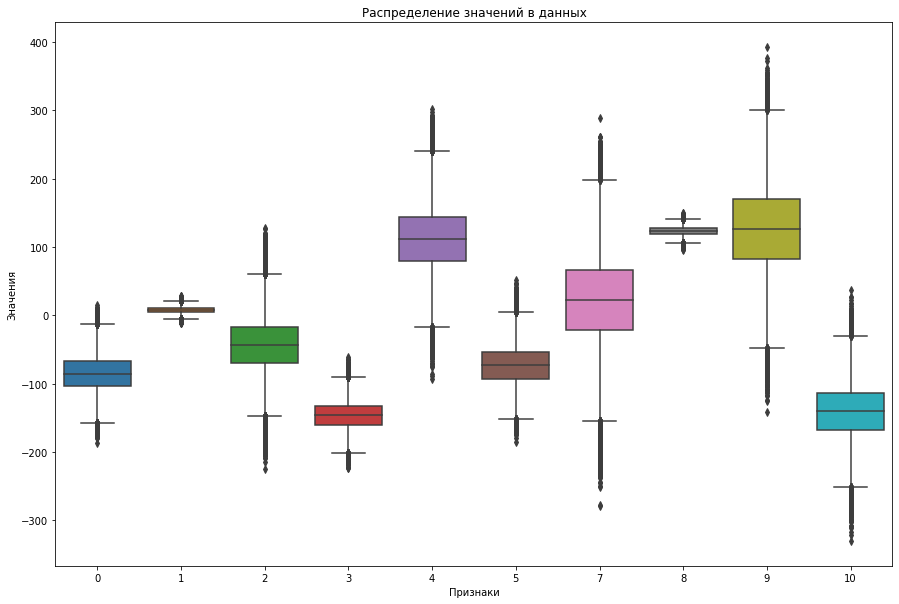

In [16]:
# смотрим разброс в данных
columns =  ['0','1','2','3','4','5','7','8','9','10']
boxplotly(data_train[columns])

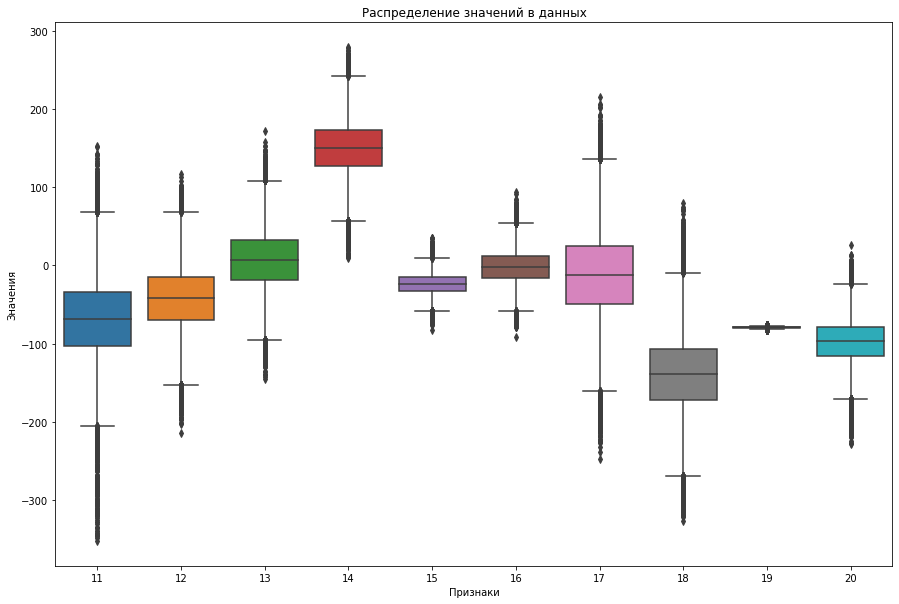

In [17]:
# смотрим разброс в данных
columns =  ['11','12','13','14','15','16','17','18','19','20']
boxplotly(data_train[columns])

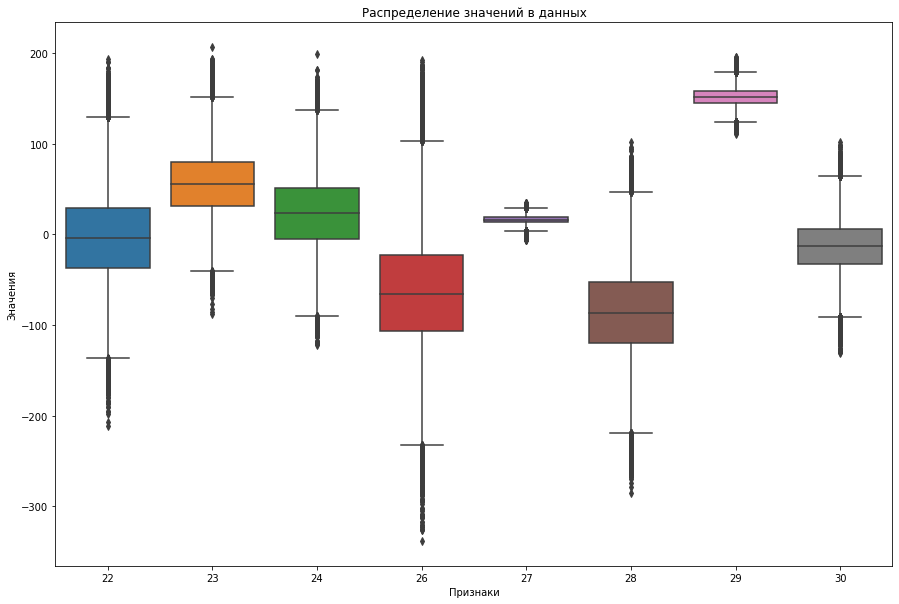

In [18]:
# смотрим разброс в данных
columns =  ['22','23','24','26','27','28','29','30']
boxplotly(data_train[columns])

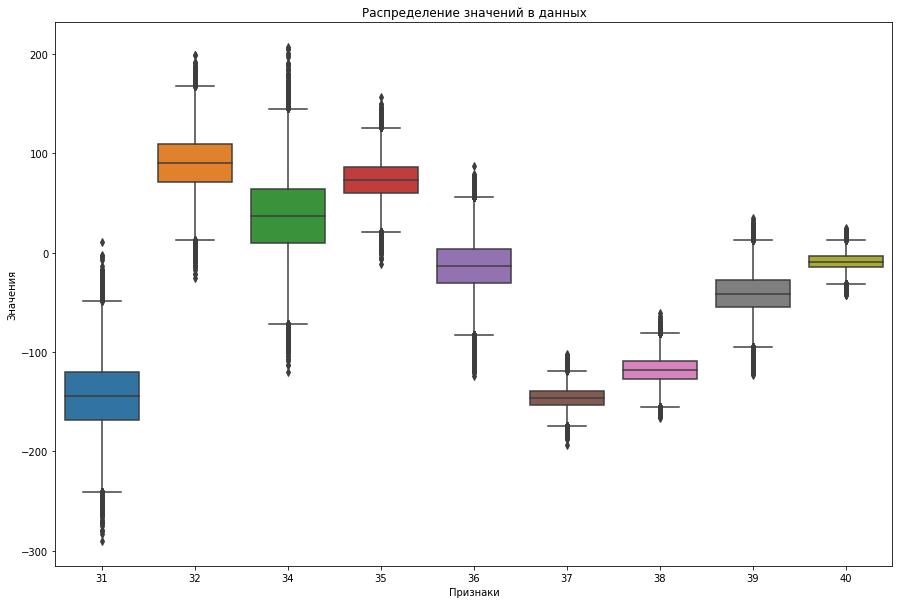

In [19]:
# смотрим разброс в данных
columns =  ['31','32','34','35','36','37','38','39','40']
boxplotly(data_train[columns])

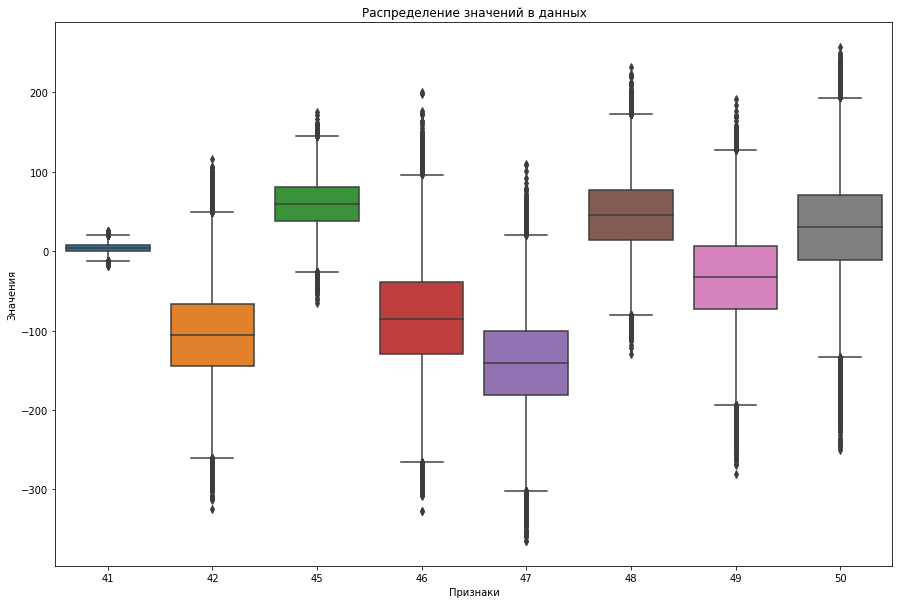

In [20]:
# смотрим разброс в данных
columns =  ['41','42','45','46','47','48','49','50']
boxplotly(data_train[columns])

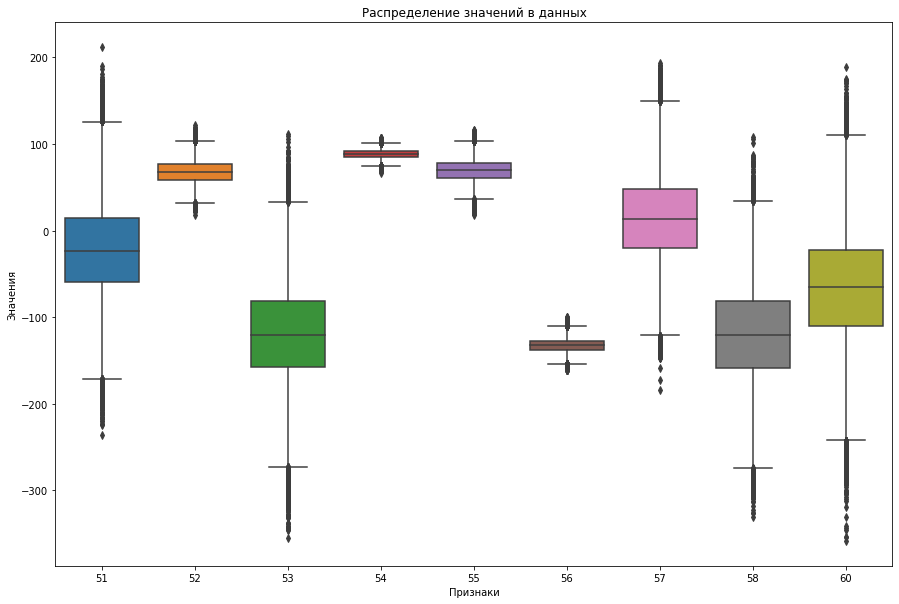

In [21]:
# смотрим разброс в данных
columns =  ['51','52','53','54','55','56','57','58','60']
boxplotly(data_train[columns])

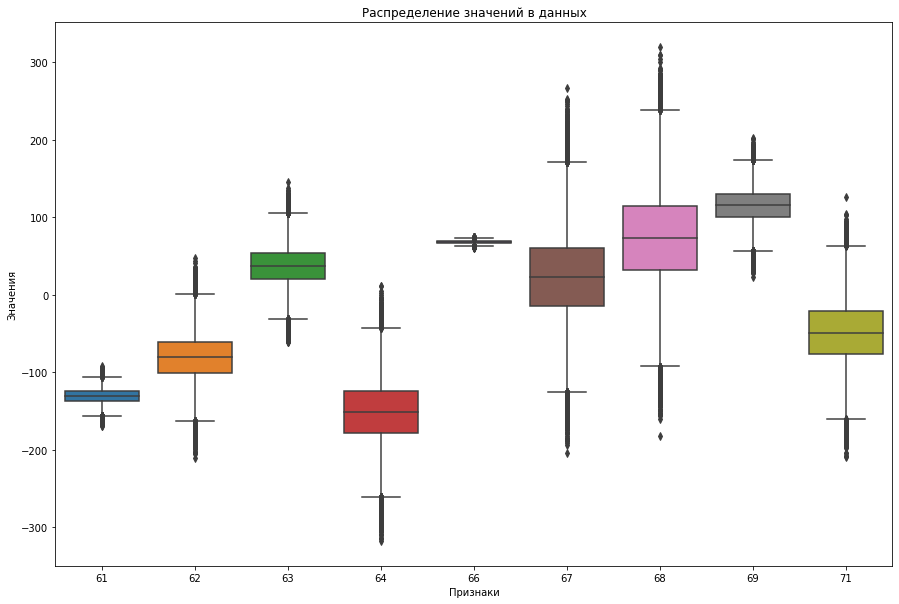

In [22]:
# смотрим разброс в данных
columns =  ['61','62','63','64','66','67','68','69','71']
boxplotly(data_train[columns])

- Выбросы наблюдаются во всех столбцах, кроме 6, 33, 44, 59, 65 и 70.

- Проверим признаки на важность

In [23]:
# зададим признаки и цель
data_train_mini = data_train.drop("Target", axis=1).sample(500)
data_train_target = data_train["Target"].sample(500)

In [24]:
# активируем модель Случайного леса
model_RFC = RandomForestClassifier(random_state=12345)
# обучаем модель на тренировочной выборке
model_RFC.fit(data_train_mini, data_train_target)
print()

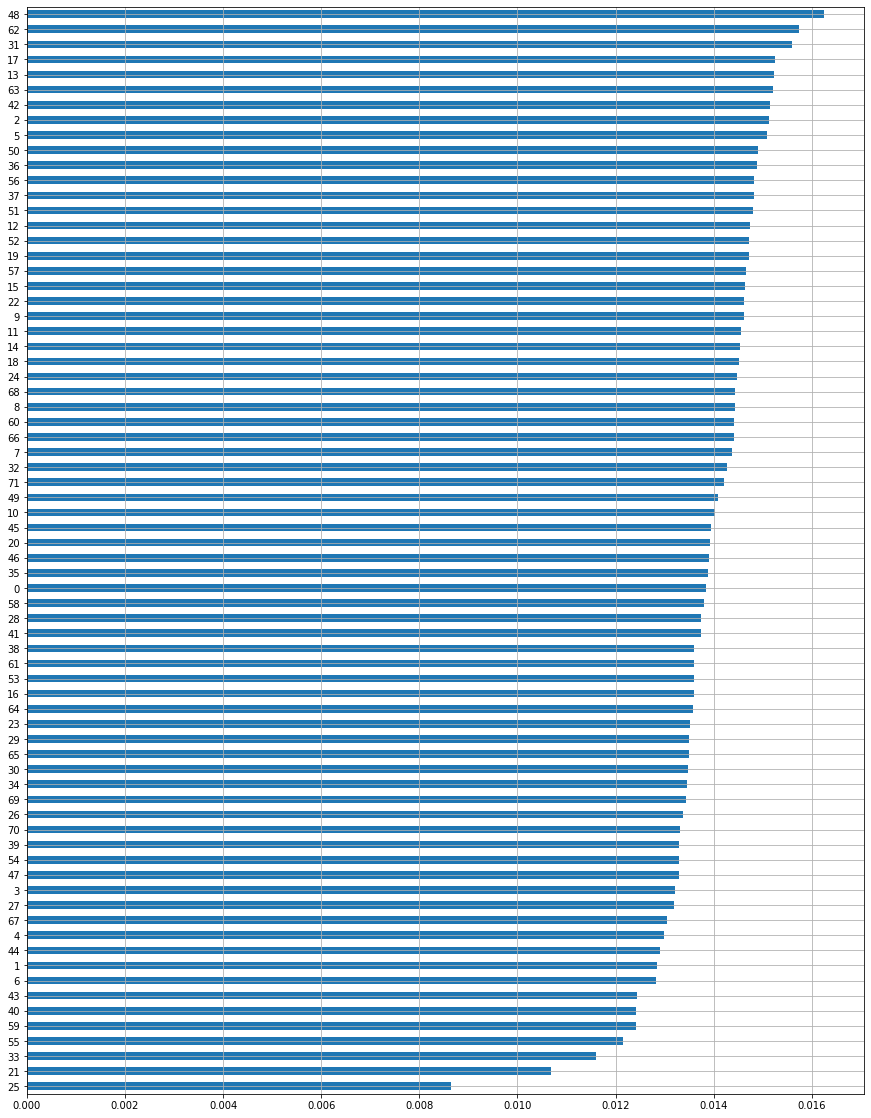

In [25]:
# строим график важности признаков
pd.Series(model_RFC.feature_importances_, index=data_train_mini.columns)\
            .sort_values(ascending=True).plot.barh(figsize=(15,20), grid=True);

### 2.1  Вывод по первому шагу

- Загрузили данные, ознакомились, определили пропуски, аномалии, дубликаты и актуальные признаки, изучили распределение и корреляцию.

- В данных отсутствуют пропуски, аномалии и дубликаты, поэтому предобработка не потребуется.

- Заменили числовые типы в данных на более экономичные.  

- Выяснили, какие признаки более важны, а какие - менее.

- Чтобы оптимизировать работу алгоритма, перед обучением избавимся от выбросов методом масштабирования. 

## 3  Создание алгоритма 

-  Сформируем выборки для обучения и предсказания. 

In [26]:
# выделяем цель и признаки в тренировочной выборке
df_train_target = data_train['Target']
df_train = data_train.drop('Target', axis=1)
# выделяем цель в  валидационной выборке
df_valid_target = data_valid_answer['Expected']

- Проведем масштабирование признаков.

In [27]:
# масштабируем численные признаки 
scaler = StandardScaler()
df_base_scaler = scaler.fit_transform(data_base)
df_train_scaler = scaler.transform(df_train)
df_valid_scaler = scaler.transform(data_valid)

# проверяем размер итоговых выборок
print(df_base_scaler.shape) 
print(df_train_scaler.shape)
print(df_valid_scaler.shape)
print(df_train_target.shape)
print(df_valid_target.shape)

(2918139, 72)
(100000, 72)
(100000, 72)
(100000,)
(100000,)


- Создадим алгоритм поиска минимальной дистанции методом ближайших соседей: решим задачу с помощью средств библиотеки FAISS.

In [28]:
# задаем константы

# задаем диапазон поиска (размер выборки)
index_part = 50000
# устанавливаем количество кластеров
n_cells = 50
# задаем количество соседей 
k = 5
# создаем словарь ID из базы
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

In [29]:
# устанавливаем размер индексных векоров 
dims = df_base_scaler.shape[1]

In [30]:
# определяем индексы для присвоения опредленному кластеру
quantizer = faiss.IndexFlatL2(dims) 

In [31]:
# строим индексы с кластеризацией
idx_l2_1 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [32]:
# получаем массив для поиска
idx_l2_1.train(np.ascontiguousarray(df_base_scaler[:index_part, :]).astype('float32'))
idx_l2_1.add(np.ascontiguousarray(df_base_scaler).astype('float32'))

- Получим предсказание на тренировочной  выборке.

In [33]:
%%time
# выполняем поиск 5 ближайших соседей 
r, idx = idx_l2_1.search(np.ascontiguousarray(df_train_scaler).astype('float32'), k)

CPU times: user 6min 19s, sys: 2.4 s, total: 6min 21s
Wall time: 1min 51s


In [34]:
# оцениваем результат поиска метрикой accuracy@5
acc = 0
for target, el in zip(df_train_target.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f"Метрика accuracy@5 на тренировочной выборке c количеством кластеров: {n_cells} = {100 * acc / len(idx)}")

Метрика accuracy@5 на тренировочной выборке c количеством кластеров: 50 = 54.981


### 3.1  Вывод по второму шагу

- Сформировали выборки и цель, избавились от выбросов, проведя масштабирование.

- Проверили работу алгоритма и получили первую оценку качества на тренировочной выборке: 54.981.

- Попробуем улучшить качество предсказания.

## 4  Улучшение работы алгоритма 

- Удалим лишние признаки.

Рассмотрим кандидатов на удаление:

- 6  - равномерное распределение значений с двумя неоднородными пиками.

- 21,25 - однородное распределение с одним высоким пиком. Значения, не попадающие в пик, обозначены как выбросы.

- 70 - однородное распределение с одним высоким пиком. Значений, распределенных однородно больше, чем находящихся внутри пика. 

- 33 - мультимодальное множество с множеством неоднородных пиков.

- 44 - однородное распределение с одним высоким пиком.

- 59, 65 - однородное распределение.

- Признаки 21, 25, 33, 6 к тому же, судя по диаграмме, имеют самую низкую важность. 

In [35]:
# удаляем лишние признаки
df_base_del = data_base.drop(['6','21','25','33','44','59','65','70'], axis=1)
df_train_del = df_train.drop(['6','21','25','33','44','59','65','70'],axis=1)
df_valid_del = data_valid.drop(['6','21','25','33','44','59','65','70'],axis=1)

In [36]:
# масштабируем численные признаки 
df_base_del_scaler = scaler.fit_transform(df_base_del)
df_train_del_scaler = scaler.transform(df_train_del)
df_valid_del_scaler = scaler.transform(df_valid_del)

# проверяем размер итоговых выборок
print(df_base_del_scaler.shape) 
print(df_train_del_scaler.shape)
print(df_valid_del_scaler.shape)
print(df_train_target.shape)
print(df_valid_target.shape)

(2918139, 64)
(100000, 64)
(100000, 64)
(100000,)
(100000,)


- Обучим алгоритм на новых данных

In [37]:
# устанавливаем размер индексных векоров 
dims = df_base_del_scaler.shape[1]

In [38]:
# определяем индексы для присвоения опредленному кластеру
quantizer = faiss.IndexFlatL2(dims) 

In [39]:
# строим индексы с кластеризацией
idx_l2_2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [40]:
# получаем массив для поиска
idx_l2_2.train(np.ascontiguousarray(df_base_del_scaler[:index_part, :]).astype('float32'))
idx_l2_2.add(np.ascontiguousarray(df_base_del_scaler).astype('float32'))

In [41]:
%%time
# выполняем поиск 5 ближайших соседей 
r, idx = idx_l2_2.search(np.ascontiguousarray(df_train_del_scaler).astype('float32'), k)

CPU times: user 5min 23s, sys: 3.15 s, total: 5min 26s
Wall time: 1min 37s


In [42]:
# оцениваем результат поиска метрикой accuracy@5
acc = 0
for target, el in zip(df_train_target.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f"Метрика accuracy@5 на тренировочной выборке c количеством кластеров: {n_cells} = {100 * acc / len(idx)}")

Метрика accuracy@5 на тренировочной выборке c количеством кластеров: 50 = 63.128


- Удаление лишних признаков повысило оценку почти на 15%. 

- Попробуем еще повысить оценку подбором оптимального количество кластеров по "методу локтя".  Так как объем данных внушительный, используем для подбора библиотеку MiniBatchKMeans.

In [43]:
# задаем базу для рассчета количества кластеров
k_base = np.ascontiguousarray(df_base_del_scaler[:index_part, :])

In [44]:
#  создаем функцию расчета количества кластеров 
def cluster_count(df, a, b, c):    
    inertia = []    
    for k in range(a,b,c):
        mbkm =  MiniBatchKMeans(n_clusters=k, 
                                init='random', 
                                random_state=12345).fit(df)
        inertia.append(np.sqrt(mbkm.inertia_))
    
    plt.figure(figsize=(10,8))    
    plt.plot(range(a,b,c), inertia, marker='o')
    plt.xlabel('Число кластеров')
    plt.ylabel('Значение целевой функции')
    plt.title('Зависимость целевой функции от количества кластеров')
    plt.show()    

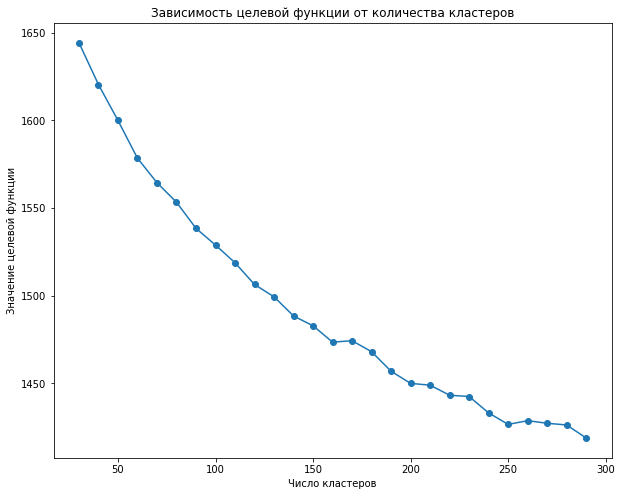

In [45]:
# выводим график
cluster_count(k_base, 30, 300, 10)

- Участок 150-250 рассмотрим более детально.

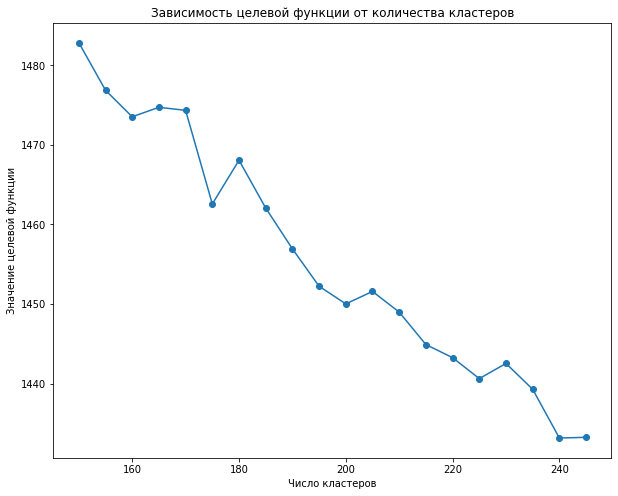

In [46]:
# выводим график
cluster_count(k_base, 150, 250, 5)

- Метод, к сожалению, не слишком информативый. На графике видно несколько пиков и провалов. Для более точного подбора воспользуемся "методом силуэта".

In [47]:
# создаем функцию рассчета количества кластеров
def cluster_siluett(df, a, b, c):
    for n_claster in range(a,b,c):
        kmeans = KMeans(n_clusters=n_claster,
                        random_state=12345).fit(df)
        label = kmeans.labels_
        sil_coeff= silhouette_score(df, label, metric='euclidean')
        print(f"Для n_claster = {n_claster}, коэффициент силуэта равен: {sil_coeff}")       

In [48]:
cluster_siluett(k_base, 170, 200, 5)

Для n_claster = 170, коэффициент силуэта равен: 0.058045707643032074
Для n_claster = 175, коэффициент силуэта равен: 0.058633700013160706
Для n_claster = 180, коэффициент силуэта равен: 0.058085571974515915
Для n_claster = 185, коэффициент силуэта равен: 0.06060464680194855
Для n_claster = 190, коэффициент силуэта равен: 0.05834738910198212
Для n_claster = 195, коэффициент силуэта равен: 0.057097554206848145


- При делении на 185 кластеров, коэффициент силуэта показывает пик. 

- Проверим работу алгоритма на вычисленном количестве кластеров.

In [49]:
# устанавливаем количество кластеров
n_cells = 185

In [50]:
# строим индексы с кластеризацией
idx_l2_3 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [51]:
# получаем массив для поиска
idx_l2_3.train(np.ascontiguousarray(df_base_del_scaler[:index_part, :]).astype('float32'))
idx_l2_3.add(np.ascontiguousarray(df_base_del_scaler).astype('float32'))

In [52]:
%%time
# выполняем поиск 5 ближайших соседей 
r, idx = idx_l2_3.search(np.ascontiguousarray(df_train_del_scaler).astype('float32'), k)

CPU times: user 1min 37s, sys: 838 ms, total: 1min 38s
Wall time: 27.7 s


In [53]:
# оцениваем результат поиска метрикой accuracy@5
acc = 0
for target, el in zip(df_train_target.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f"Метрика accuracy@5 на тренировочной выборке c количеством кластеров: {n_cells} = {100 * acc / len(idx)}")

Метрика accuracy@5 на тренировочной выборке c количеством кластеров: 185 = 62.796


- Метод, к сожалению, не принес желаемого результата: оценка не повысилась.

- Попробуем изменить в алгоритме количество просматриваемых соседних кластеров.

In [54]:
# устанавливаем количество кластеров
n_cells = 185
# устанавливаем количество ближайших кластеров
n_probe = 10

In [55]:
# строим индексы с кластеризацией
idx_l2_4 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [56]:
idx_l2_4.nprobe = n_probe

In [57]:
# получаем массив для поиска
idx_l2_4.train(np.ascontiguousarray(df_base_del_scaler[:index_part, :]).astype('float32'))
idx_l2_4.add(np.ascontiguousarray(df_base_del_scaler).astype('float32'))

In [58]:
%%time
# выполняем поиск 5 ближайших соседей 
r, idx = idx_l2_4.search(np.ascontiguousarray(df_train_del_scaler).astype('float32'), k)

CPU times: user 15min 35s, sys: 5 s, total: 15min 40s
Wall time: 4min 21s


In [59]:
# оцениваем результат поиска метрикой accuracy@5
acc = 0
for target, el in zip(df_train_target.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f"Метрика accuracy@5 на тренировочной выборке\
 c количеством кластеров: {n_cells} и поиском по {n_probe} соседним = {100 * acc / len(idx)}")

Метрика accuracy@5 на тренировочной выборке c количеством кластеров: 185 и поиском по 10 соседним = 70.269


### 4.1  Вывод по третьему шагу

- Удалилили лишние признаки и запустили алгоритм на новых даннных.

- После удаления лишних признаков оценка выросла почти на 15%.

- Подобрали опимальное количество кластеров "методом локтя" и "методом  силуэта" и проверили качество предсказания на подобранном количестве. Подбор кластеров оценку не повысил. 

- Изменили количество соседних кластеров для поиска до 10, что повысило оценку еще на 11%.

- Проверим финальный алгоритм на валидационной выборке.

## 5  Проверка алгоритма на тестовой выборке

- Получим предсказание алгоритма с отобранными параметрами на валидационной выборке.

In [60]:
%%time
# выполняем поиск 5 ближайших соседей 
r, idx = idx_l2_4.search(np.ascontiguousarray(df_valid_del_scaler).astype('float32'), k)

CPU times: user 15min 17s, sys: 5.11 s, total: 15min 22s
Wall time: 4min 29s


In [61]:
# оцениваем результат поиска метрикой accuracy@5
acc = 0
for target, el in zip(df_valid_target.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(f"Метрика accuracy@5 на валидационной выборке\
 c количеством кластеров: {n_cells} и поиском по {n_probe} соседним = {100 * acc / len(idx)}")

Метрика accuracy@5 на валидационной выборке c количеством кластеров: 185 и поиском по 10 соседним = 70.139


### 5.1  Вывод по четвертому шагу

- Проверили алгоритм с лучшей оценкой на тестовой выборке: алгоритм показал почти такую же оценку (70,139), что и на тренировочной выборке. 


## 6  Общий вывод

- В результате работы над проетом мы:

 - Загрузили данные.

 - Провелти EDA.
 
 - Разработали ранжирующий алгоритм методом приближенного поиска ближайших соседей, используя возможности библиотеки FAISS.
 
 - Измерили качество алгоритма метрикой accuracy@5.
 
 - Проверили работу алгоритма на разных параметрах и отобрали лучшие.
 
 - Проверили алгоритм с лучшей оценкой на тестовой выборке.
 
 
 **Резюме:**

**Наибольшее влияние** на уровень оценки оказало **удаление лишних признаков** и увеличение количества соседних кластеров.


**Время поиска** ответов **пропорционально количеству кластеров** и количеству соседних.


**Лучшую метрику (70.269)** на тренировочной выборке показал алгоритм c количеством **кластеров: 185** и поиском по **10 соседним.**


**На тестовой выборке** алгоритм с аналогичными параметрами показал **метрику 70.139**.
